In [1]:
import isaac.constants
isaac.constants.TQDM_DISABLE = True

from torch import nn
from isaac.utils import get_cuda_device_if_available
import joblib

from isaac.dataset import read_dataset, prepare_dataset
from isaac.models import MultiBranchModel
from isaac.constants import BASIC_TRAINING_COLS, MASS_CLASS_COLS, FORCE_CLASS_COLS, RTHETA_COLS, XY_RTHETA_COLS, XY_VXVY_RTHETA_COLS
from isaac.evaluation import evaluate_saved_model
from isaac.statistical_tests import z_test
from isaac.visualization import plot_confusion_matrix

from scipy.stats import ttest_ind, ttest_rel, f_oneway

import torch
import glob
from torch.autograd import Variable
import numpy as np
import pandas as pd
from tqdm import tqdm

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
device = get_cuda_device_if_available()
print(device)

cpu


In [3]:
normalise_data = True
model_name = "xy_vxvy"
training_columns = BASIC_TRAINING_COLS
scaler_path = "scalers/passive_"+model_name+"_scaler.sk"
# scaler_path = "scalers/passive_r_data_scaler.sk"
# scaler_path = "scalers/passive_rtheta_scaler.sk"
# scaler_path = "scalers/passive_r_data_scaler.sk"
network_dims = (len(training_columns), 25, 3, 0.5)
dataset_path = "../new_exp_data/exp7_passive_rtheta.h5"
class_columns = [list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)]
multiclass = True
seq_end = 2700
step_size = 3
N_MODELS = None


def get_question_accuracy_for_group_of_models(question_type):
    global N_MODELS
    model_paths = tqdm(sorted(glob.glob("models/"+model_name+"/best_"+question_type+"_model_seed_*.pt")))
    N_MODELS = len(model_paths)

    accuracies, predicted = evaluate_saved_model(model_paths, network_dims, dataset_path, 
                                                 training_columns=training_columns, class_columns=class_columns, 
                                                 step_size=step_size, seq_end=seq_end, scaler_path=scaler_path,
                                                 arch=MultiBranchModel, multiclass=multiclass, trials=None)
    
    if question_type == "mass":
        question_index = 0
    else:
        question_index = 1

    accuracies = np.stack(accuracies)[:, question_index]
    
    predicted = [x[:, question_index].cpu().numpy() for x in predicted]

    return accuracies, predicted

In [4]:
def get_participant_accuracy_filtering_by_answer(passive_responses, answer_column, question_type_answer, filter_by_class):
    
    passive_responses = passive_responses.copy().query(question_type_answer+" == "+filter_by_class)
    return passive_responses[answer_column]

# T-test for MASS questions

## Load model's predictions

In [5]:
print("MASS")
question_type = "mass"
group_mass_acc, group_mass_prediction = get_question_accuracy_for_group_of_models(question_type)
     
print("\nFORCE")
question_type = "force"
group_force_acc, group_force_prediction = get_question_accuracy_for_group_of_models(question_type)

  0%|          | 0/25 [00:00<?, ?it/s]

MASS


  0%|          | 0/25 [00:00<?, ?it/s]


FORCE


100%|██████████| 25/25 [00:16<00:00,  1.95it/s]


In [6]:
group_mass_prediction = np.array(group_mass_prediction)
group_force_prediction = np.array(group_force_prediction)

In [7]:
answers = []
for question_i in range(group_mass_prediction.shape[1]):
    
    mass_predictions = list(group_mass_prediction[:, question_i])
    question_mass_counts = [mass_predictions.count(key) for key in range(3)]
    question_mass_percentages = [mass_predictions.count(key) / N_MODELS for key in range(3)]
        
    force_predictions = list(group_force_prediction[:, question_i])
    question_force_counts = [force_predictions.count(key) for key in range(3)]
    question_force_percentages = [force_predictions.count(key) / N_MODELS for key in range(3)]
    
    answers.append(np.hstack((question_mass_counts, question_mass_percentages, question_force_counts, question_force_percentages)))
    
model_answers_df = pd.DataFrame(data=answers,
                                columns=["A_models", "B_models", "same_models",
                                         "A_per_models", "B_per_models", "same_per_models",
                                         "attract_models", "none_models", "repel_models",
                                         "attract_per_models", "none_per_models", "repel_per_models",
                                        ])

model_answers_df[[cl + "_models" for cl in MASS_CLASS_COLS]] = model_answers_df[[cl + "_models" for cl in MASS_CLASS_COLS]].astype(int)
model_answers_df[[cl + "_models" for cl in FORCE_CLASS_COLS]] = model_answers_df[[cl + "_models" for cl in FORCE_CLASS_COLS]].astype(int)

In [8]:
model_answers_df.head()

,A_models,B_models,same_models,A_per_models,B_per_models,same_per_models,attract_models,none_models,repel_models,attract_per_models,none_per_models,repel_per_models
0,11,0,14,0.44,0.00,0.56,23,2,0,0.92,0.08,0.00
1,21,1,3,0.84,0.04,0.12,25,0,0,1.00,0.00,0.00
2,0,25,0,0.00,1.00,0.00,25,0,0,1.00,0.00,0.00
3,6,1,18,0.24,0.04,0.72,0,23,2,0.00,0.92,0.08
4,14,0,11,0.56,0.00,0.44,4,21,0,0.16,0.84,0.00


In [9]:
import json

In [10]:
condition_world_variant = []
world_id = []

for condition_id in range(1, 5):
    filename = "../new_exp_data/physics_data%d.json" % condition_id
    fd = open(filename)
    sim_data = json.load(fd)
    
    for sim in sim_data:
        if sim["practice"]:
            continue
        condition_world_variant.append(sim["condition_world_variant"])
        world_id.append(sim["world_id"])

In [11]:
model_answers_df["condition_world_variant"] = condition_world_variant
model_answers_df["world_id"] = world_id

## Load human results

In [12]:
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

In [13]:
rdata_path = "../new_exp_data/e7_passive_io_rtheta.rdata"
r['load'](rdata_path)

responses = r["tw"].query("practice == 0")

# Percentage of participants that get an answer right

In [14]:
passive_responses = []

for name, df in responses.groupby(["cond_worldvar", "world_id", "true_mass", "true_rel",
                                   "post_ent_mass.rtheta", "post_ent_rel.rtheta",
                                   "post_att.rtheta", "post_none.rtheta", "post_rep.rtheta", 
                                   "post_same.rtheta", "post_A.rtheta", "post_B.rtheta"]):
    response = [name[0], name[1], name[2], name[3], name[4], name[5],
               name[6], name[7], name[8], name[9], name[10], name[11]]

    value_counts = df.resp_rel.value_counts()
    force_human_accuracy = value_counts[name[3]] / value_counts.sum()     
    response.append(force_human_accuracy)
    
    for cl in FORCE_CLASS_COLS:
        response.append(value_counts[cl])
    
    value_counts = df.resp_mass.value_counts()
    mass_human_accuracy = value_counts[name[2]] / value_counts.sum()     
    response.append(mass_human_accuracy)    
    for cl in MASS_CLASS_COLS:
        response.append(value_counts[cl])
        
    passive_responses.append(response)

In [15]:
passive_responses = pd.DataFrame(data=passive_responses, 
                                 columns=["cond_worldvar", "world_id", "true_mass", "true_rel",  "post_ent_mass.rtheta", 
                                          "post_ent_rel.rtheta" ,"attract_io", "none_io", "repel_io", "same_io", "A_io", "B_io",
                                          "force_human_accuracy", "attract_humans", "none_humans", "repel_humans",
                                          "mass_human_accuracy", "A_humans", "B_humans", "same_humans"])

In [16]:
passive_responses.head()

,cond_worldvar,world_id,true_mass,true_rel,post_ent_mass.rtheta,post_ent_rel.rtheta,attract_io,none_io,repel_io,same_io,A_io,B_io,force_human_accuracy,attract_humans,none_humans,repel_humans,mass_human_accuracy,A_humans,B_humans,same_humans
0,1,1218,A,repel,0.000827,1.402287,0.116278,0.442520,0.441202,0.000053,9.999471e-01,1.306524e-10,0.76,4,2,19,0.52,13,5,7
1,1,1736,B,none,0.022527,1.413136,0.294347,0.549061,0.156592,0.002171,1.061167e-05,9.978184e-01,0.40,2,10,13,0.52,4,13,8
2,1,1758,B,repel,0.049913,1.555458,0.241375,0.368009,0.390617,0.005595,3.771451e-08,9.944045e-01,0.44,8,6,11,0.72,1,18,6
3,1,1819,B,attract,0.243940,0.924914,0.736875,0.245450,0.017676,0.040165,5.755379e-05,9.597772e-01,0.64,16,1,8,0.60,5,15,5
4,1,438,same,repel,0.051500,1.305047,0.127337,0.250658,0.622005,0.994825,1.722333e-03,3.453153e-03,0.56,4,7,14,0.36,7,9,9


In [17]:
passive_responses["cond_worldvar"] = passive_responses["cond_worldvar"].astype("int64")
passive_responses["world_id"] = passive_responses["world_id"].astype("int64")

passive_responses = passive_responses.merge(model_answers_df, left_on=["cond_worldvar", "world_id"], right_on=["condition_world_variant", "world_id"])

In [18]:
passive_responses.columns

Index(['cond_worldvar', 'world_id', 'true_mass', 'true_rel',
       'post_ent_mass.rtheta', 'post_ent_rel.rtheta', 'attract_io', 'none_io',
       'repel_io', 'same_io', 'A_io', 'B_io', 'force_human_accuracy',
       'attract_humans', 'none_humans', 'repel_humans', 'mass_human_accuracy',
       'A_humans', 'B_humans', 'same_humans', 'A_models', 'B_models',
       'same_models', 'A_per_models', 'B_per_models', 'same_per_models',
       'attract_models', 'none_models', 'repel_models', 'attract_per_models',
       'none_per_models', 'repel_per_models', 'condition_world_variant'],
      dtype='object')

# RNN accuracy

In [19]:
mass_rnn_accuracy = []
mass_io_posterior = []

for i, answer in enumerate(passive_responses.true_mass):
    mass_rnn_accuracy.append(passive_responses[answer + "_per_models"].iloc[i])
    mass_io_posterior.append(passive_responses[answer + "_io"].iloc[i])
    
force_rnn_accuracy = []
force_io_posterior = []  
for i, answer in enumerate(passive_responses.true_rel):
    force_rnn_accuracy.append(passive_responses[answer + "_per_models"].iloc[i])
    force_io_posterior.append(passive_responses[answer + "_io"].iloc[i])
    
passive_responses["mass_rnn_accuracy"] = np.array(mass_rnn_accuracy)
passive_responses["mass_io_posterior"] = np.array(mass_io_posterior)

passive_responses["force_rnn_accuracy"] = np.array(force_rnn_accuracy)
passive_responses["force_io_posterior"] = np.array(force_io_posterior)

In [20]:
passive_responses.head()

,cond_worldvar,world_id,true_mass,true_rel,post_ent_mass.rtheta,post_ent_rel.rtheta,attract_io,none_io,repel_io,same_io,...,none_models,repel_models,attract_per_models,none_per_models,repel_per_models,condition_world_variant,mass_rnn_accuracy,mass_io_posterior,force_rnn_accuracy,force_io_posterior
0,1,1218,A,repel,0.000827,1.402287,0.116278,0.442520,0.441202,0.000053,...,10,15,0.0,0.40,0.60,1,1.00,0.999947,0.60,0.441202
1,1,1736,B,none,0.022527,1.413136,0.294347,0.549061,0.156592,0.002171,...,20,0,0.2,0.80,0.00,1,1.00,0.997818,0.80,0.549061
2,1,1758,B,repel,0.049913,1.555458,0.241375,0.368009,0.390617,0.005595,...,2,23,0.0,0.08,0.92,1,1.00,0.994405,0.92,0.390617
3,1,1819,B,attract,0.243940,0.924914,0.736875,0.245450,0.017676,0.040165,...,0,0,1.0,0.00,0.00,1,1.00,0.959777,1.00,0.736875
4,1,438,same,repel,0.051500,1.305047,0.127337,0.250658,0.622005,0.994825,...,17,8,0.0,0.68,0.32,1,0.64,0.994825,0.32,0.622005


In [21]:
human_mass_accuracy_list = passive_responses.mass_human_accuracy
human_force_accuracy_list = passive_responses.force_human_accuracy

model_mass_accuracy_list = passive_responses.mass_rnn_accuracy
model_force_accuracy_list = passive_responses.force_rnn_accuracy

io_mass_posterior_list = passive_responses.mass_io_posterior
io_force_posterior_list = passive_responses.force_io_posterior

# Perform t-test on overall accuracy

In [22]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns

sns.set(font_scale=2)
sns.set_style("white")
plt.rc('font', weight='bold')

In [23]:
print(np.mean(human_mass_accuracy_list), "±", np.std(human_mass_accuracy_list))
print(np.mean(model_mass_accuracy_list), "±", np.std(model_mass_accuracy_list))
print(np.mean(io_mass_posterior_list), "±", np.std(io_mass_posterior_list))

0.37839031339031337 ± 0.145973580677441
0.6444444444444445 ± 0.2893329919779519
0.9732832819889428 ± 0.07393349954378448


In [24]:
print(np.mean(human_force_accuracy_list), "±", np.std(human_force_accuracy_list))
print(np.mean(model_force_accuracy_list), "±", np.std(model_force_accuracy_list))
print(np.mean(io_force_posterior_list), "±", np.std(io_force_posterior_list))

0.5462250712250714 ± 0.176816239172785
0.7855555555555556 ± 0.2253200741222786
0.6066807825159446 ± 0.18170704663896928


In [25]:
from sklearn.linear_model import LinearRegression
max_entropy = -np.sum([1/3, 1/3, 1/3] * np.log2([1/3, 1/3, 1/3]))

def plot_correlation(human_accuracy_list, model_accuracy_list, solutions, xlabel="RNN accuracy", savepath=None):
    
    print("Pearson corr", np.corrcoef(model_accuracy_list, human_accuracy_list)[0][1])
    corr, pval = spearmanr(model_accuracy_list, human_accuracy_list)
    print("Spearman pval", pval)
    df = pd.DataFrame({"Human accuracy": human_accuracy_list, xlabel: model_accuracy_list, "solution": solutions})
    plt.figure(figsize=(8, 6))
    sns.regplot(x=xlabel, y="Human accuracy", data=df, scatter_kws={"s": 100})
    plt.title("$r_s$ = %.3f" % corr, weight="bold", size=30)
    plt.ylabel("Human accuracy", weight="bold")
    plt.xlabel(xlabel, weight="bold")
    sns.despine()
    
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()

Pearson corr 0.37380824182075884
Spearman pval 0.01637954940682536


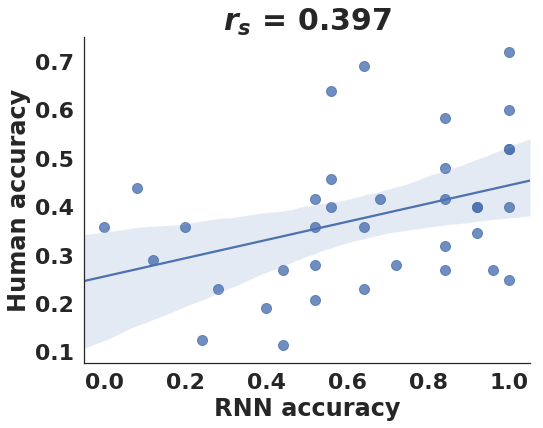

Pearson corr 0.022796588322583095
Spearman pval 0.500740783372535


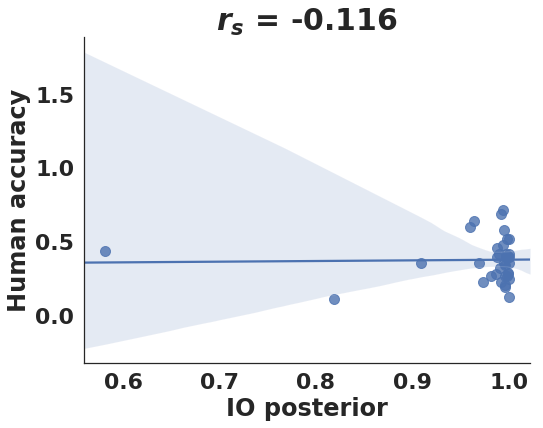

In [26]:
plot_correlation(human_mass_accuracy_list, model_mass_accuracy_list, passive_responses.true_mass,
                savepath="cogsci_images/rnn_accuracy_vs_human_accuracy_mass.pdf")
plot_correlation(human_mass_accuracy_list, io_mass_posterior_list, passive_responses.true_mass, "IO posterior",
                savepath="cogsci_images/io_posterior_vs_human_accuracy_mass.pdf")

Pearson corr -0.023637057515267325
Spearman pval 0.8132260886291512


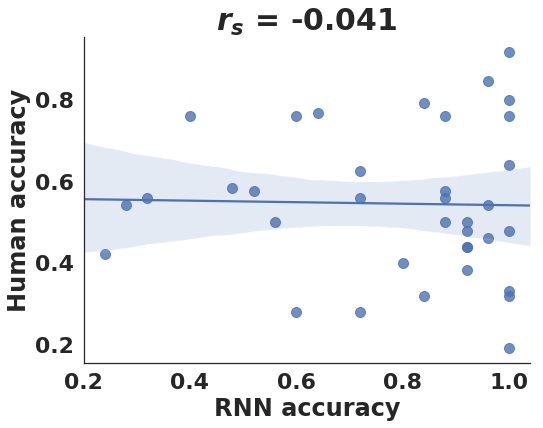

Pearson corr 0.10287547142564349
Spearman pval 0.45690845308930605


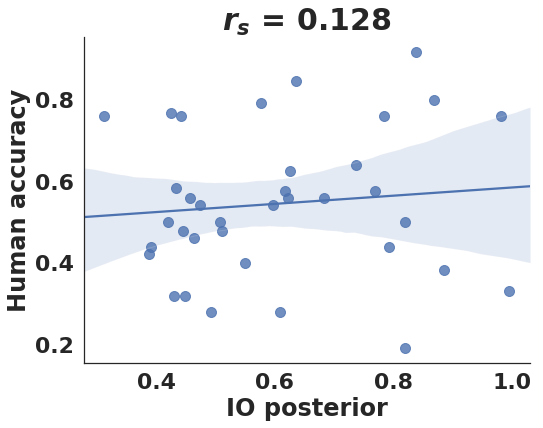

In [27]:
plot_correlation(human_force_accuracy_list, model_force_accuracy_list, 
                 passive_responses.true_rel, savepath="cogsci_images/rnn_accuracy_vs_human_accuracy_force.pdf")
plot_correlation(human_force_accuracy_list, io_force_posterior_list, passive_responses.true_rel, "IO posterior",
                 savepath="cogsci_images/io_posterior_vs_human_accuracy_force.pdf")

#### Is the model significantly better answering mass questions than humans?

In [28]:
ttest_rel(human_mass_accuracy_list, model_mass_accuracy_list)

Ttest_relResult(statistic=-5.807898983002914, pvalue=1.3830695458606912e-06)

#### Does the IO significantly overestimate mass accuracy for humans?

In [29]:
ttest_rel(io_mass_posterior_list, model_mass_accuracy_list)

Ttest_relResult(statistic=7.28299635558898, pvalue=1.6539015037382325e-08)

#### Is the model significantly better answering mass questions than humans?

In [30]:
ttest_rel(human_force_accuracy_list, model_force_accuracy_list)

Ttest_relResult(statistic=-4.8877420884881495, pvalue=2.2508812363228324e-05)

#### Does the IO significantly overestimate force accuracy for humans?

In [31]:
ttest_rel(human_force_accuracy_list, io_force_posterior_list)

Ttest_relResult(statistic=-1.4893369024447796, pvalue=0.1453553400487548)

#### Is the model significantly better answering force questions than mass questions? And humans?

In [32]:
print(ttest_ind(model_mass_accuracy_list, model_force_accuracy_list))
print(ttest_ind(human_mass_accuracy_list, human_force_accuracy_list))
print(ttest_ind(io_mass_posterior_list, io_force_posterior_list))

Ttest_indResult(statistic=-2.2764703483018285, pvalue=0.025878961572689138)
Ttest_indResult(statistic=-4.3304952743613745, pvalue=4.86608749152777e-05)
Ttest_indResult(statistic=11.055834365177166, pvalue=5.216084466344975e-17)


# Is the model better at predicting any force class?

In [33]:
repel_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "force_rnn_accuracy", 
                                                                   "true_rel", "'repel'")

none_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "force_rnn_accuracy", 
                                                                   "true_rel", "'none'")

attract_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "force_rnn_accuracy", 
                                                                   "true_rel", "'attract'")

In [34]:
print(np.mean(repel_accuracy_list), np.std(repel_accuracy_list))
print(np.mean(none_accuracy_list), np.std(none_accuracy_list))
print(np.mean(attract_accuracy_list), np.std(attract_accuracy_list))

print()

print(ttest_ind(repel_accuracy_list, none_accuracy_list))
print(ttest_ind(repel_accuracy_list, attract_accuracy_list))
print(ttest_ind(attract_accuracy_list, none_accuracy_list))

0.6233333333333334 0.2235819511697867
0.8033333333333333 0.21875912679373075
0.93 0.0834665601703261

Ttest_indResult(statistic=-1.9085377821897775, pvalue=0.06945444991128683)
Ttest_indResult(statistic=-4.261817702431131, pvalue=0.00031830467668088764)
Ttest_indResult(statistic=1.7942393067555873, pvalue=0.08653078455249802)


# Are humans better at predicting any force class? And compared to RNNs?

In [35]:
human_repel_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "force_human_accuracy", 
                                                                         "true_rel", "'repel'")

human_none_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "force_human_accuracy", 
                                                                        "true_rel", "'none'")

human_attract_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "force_human_accuracy", 
                                                                   "true_rel", "'attract'")

print(np.mean(human_repel_accuracy_list), np.std(human_repel_accuracy_list))
print(np.mean(human_none_accuracy_list), np.std(human_none_accuracy_list))
print(np.mean(human_attract_accuracy_list), np.std(human_attract_accuracy_list))


print()

print(ttest_ind(human_repel_accuracy_list, human_none_accuracy_list))
print(ttest_ind(human_repel_accuracy_list, human_attract_accuracy_list))
print(ttest_ind(human_attract_accuracy_list, human_none_accuracy_list))

0.5727350427350427 0.13531888148325485
0.38777777777777783 0.10039803172690473
0.6781623931623932 0.14894697893841963

Ttest_indResult(statistic=3.640639395027706, pvalue=0.0014428896714880582)
Ttest_indResult(statistic=-1.7375664164447775, pvalue=0.09626821719795242)
Ttest_indResult(statistic=5.361722481943239, pvalue=2.204329106568638e-05)


In [36]:
print(ttest_rel(repel_accuracy_list, human_repel_accuracy_list))
print(ttest_rel(none_accuracy_list, human_none_accuracy_list))
print(ttest_rel(attract_accuracy_list, human_attract_accuracy_list))

Ttest_relResult(statistic=0.5588243859174922, pvalue=0.5874773443309753)
Ttest_relResult(statistic=5.270070223868354, pvalue=0.0002642896131964433)
Ttest_relResult(statistic=5.146140681693536, pvalue=0.000320160075499065)


# Is the model better at predicting any mass class?

In [37]:
a_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "mass_rnn_accuracy", 
                                                                   "true_mass", "'A'")

same_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "mass_rnn_accuracy", 
                                                                   "true_mass", "'same'")

b_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "mass_rnn_accuracy", 
                                                                   "true_mass", "'B'")

In [38]:
print(np.mean(a_accuracy_list), np.std(a_accuracy_list))
print(np.mean(same_accuracy_list), np.std(same_accuracy_list))
print(np.mean(b_accuracy_list), np.std(b_accuracy_list))

print()

print(ttest_ind(a_accuracy_list, same_accuracy_list))
print(ttest_ind(a_accuracy_list, b_accuracy_list))
print(ttest_ind(b_accuracy_list, same_accuracy_list))

0.5866666666666668 0.3291740505500936
0.5133333333333334 0.210923893594085
0.8333333333333334 0.20515576737905492

Ttest_indResult(statistic=0.6221182473580422, pvalue=0.5402587675698031)
Ttest_indResult(statistic=-2.1092046986617294, pvalue=0.04653687816769886)
Ttest_indResult(statistic=3.606974762935241, pvalue=0.0015649496909802064)


# Are humans better at predicting any mass class? And compared to RNNs?

In [39]:
human_a_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "mass_human_accuracy", 
                                                                     "true_mass", "'A'")

human_same_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "mass_human_accuracy", 
                                                                        "true_mass", "'same'")

human_b_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "mass_human_accuracy", 
                                                                     "true_mass", "'B'")

print(np.mean(human_a_accuracy_list), np.std(human_a_accuracy_list))
print(np.mean(human_same_accuracy_list), np.std(human_same_accuracy_list))
print(np.mean(human_b_accuracy_list), np.std(human_b_accuracy_list))

print()

print()

print(ttest_ind(human_a_accuracy_list, human_same_accuracy_list))
print(ttest_ind(human_a_accuracy_list, human_b_accuracy_list))
print(ttest_ind(human_b_accuracy_list, human_same_accuracy_list))

0.4100427350427351 0.14185875067409623
0.30391025641025643 0.11751739115262044
0.42121794871794865 0.14699406576210686


Ttest_indResult(statistic=1.9108454864102784, pvalue=0.0691424586904233)
Ttest_indResult(statistic=-0.1814353668752333, pvalue=0.8576870862868097)
Ttest_indResult(statistic=2.0673466990693723, pvalue=0.050664413609717754)


In [40]:
print(ttest_rel(a_accuracy_list, human_a_accuracy_list))
print(ttest_rel(same_accuracy_list, human_same_accuracy_list))
print(ttest_rel(b_accuracy_list, human_b_accuracy_list))

Ttest_relResult(statistic=1.7794325516729408, pvalue=0.10277797774233978)
Ttest_relResult(statistic=3.365642273817199, pvalue=0.0063006389523802345)
Ttest_relResult(statistic=7.1216744686273366, pvalue=1.9381641939435856e-05)


# CONFUSION MATRICES

In [41]:
mass_solutions_with_participant_size = []
force_solutions_with_participant_size = []
human_mass_answers = []
human_force_answers = []

mass_solutions_with_model_size = []
force_solutions_with_model_size = []
model_mass_answers = []
model_force_answers = []

for row in range(passive_responses.shape[0]):
    mass_solution = passive_responses.iloc[row].true_mass
    force_solution = passive_responses.iloc[row].true_rel
    
    human_mass_answers.extend(["A" for _ in range(passive_responses.iloc[row].A_humans)])
    human_mass_answers.extend(["B" for _ in range(passive_responses.iloc[row].B_humans)])
    human_mass_answers.extend(["same" for _ in range(passive_responses.iloc[row].same_humans)])
    mass_solutions_with_participant_size.extend([mass_solution for _ in 
                                                 range(passive_responses.iloc[row].A_humans 
                                                        + passive_responses.iloc[row].B_humans
                                                        + passive_responses.iloc[row].same_humans)])

    
    human_force_answers.extend(["attract" for _ in range(passive_responses.iloc[row].attract_humans)])
    human_force_answers.extend(["repel" for _ in range(passive_responses.iloc[row].repel_humans)])
    human_force_answers.extend(["none" for _ in range(passive_responses.iloc[row].none_humans)])
    force_solutions_with_participant_size.extend([force_solution for _ in 
                                             range(passive_responses.iloc[row].attract_humans 
                                                    + passive_responses.iloc[row].repel_humans
                                                    + passive_responses.iloc[row].none_humans)])

    model_mass_answers.extend(["A" for _ in range(passive_responses.iloc[row].A_models)])
    model_mass_answers.extend(["B" for _ in range(passive_responses.iloc[row].B_models)])
    model_mass_answers.extend(["same" for _ in range(passive_responses.iloc[row].same_models)])
    mass_solutions_with_model_size.extend([mass_solution for _ in 
                                                 range(passive_responses.iloc[row].A_models 
                                                        + passive_responses.iloc[row].B_models
                                                        + passive_responses.iloc[row].same_models)])    
    
    
    model_force_answers.extend(["attract" for _ in range(passive_responses.iloc[row].attract_models)])
    model_force_answers.extend(["repel" for _ in range(passive_responses.iloc[row].repel_models)])
    model_force_answers.extend(["none" for _ in range(passive_responses.iloc[row].none_models)])
    force_solutions_with_model_size.extend([force_solution for _ in 
                                         range(passive_responses.iloc[row].attract_models 
                                                + passive_responses.iloc[row].repel_models
                                                + passive_responses.iloc[row].none_models)])

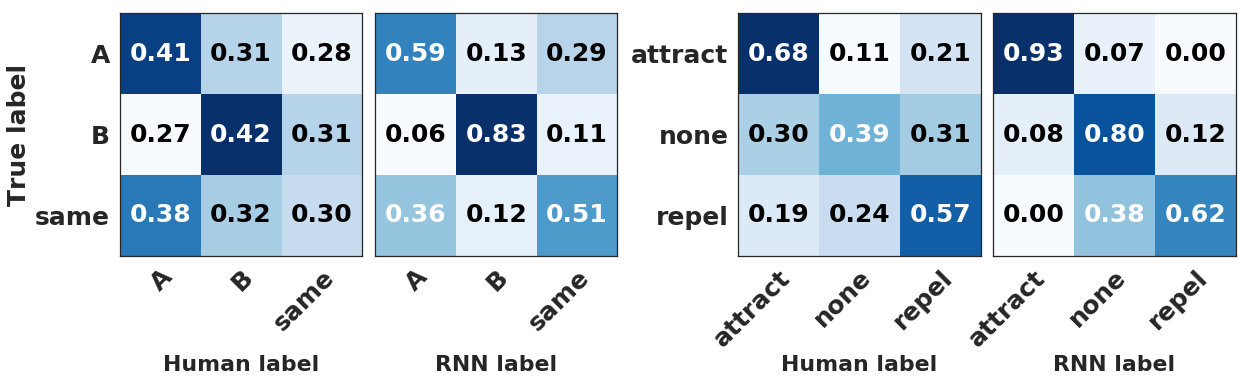

In [42]:
fig, axis = plt.subplots(1, 4, figsize=(20, 9))

ax = plot_confusion_matrix(mass_solutions_with_participant_size, human_mass_answers, MASS_CLASS_COLS, ax=axis[0], normalize=True)
ax.set_ylabel("True label", fontsize=25, fontweight='bold')
ax.set_xlabel("Human label", fontsize=22, fontweight='bold')
ax.tick_params(axis="both", labelsize=25)
ax.set_xticklabels(MASS_CLASS_COLS, fontweight='bold')
ax.set_yticklabels(MASS_CLASS_COLS, fontweight='bold')

ax = plot_confusion_matrix(mass_solutions_with_model_size, model_mass_answers, MASS_CLASS_COLS, ax=axis[1], normalize=True)
ax.set_ylabel("", fontsize=25)
ax.set_xlabel("RNN label", fontsize=22, fontweight='bold')
ax.tick_params(axis="both", labelsize=25)
ax.set_xticklabels(MASS_CLASS_COLS, fontweight='bold')
ax.set_yticks([])
# ax.set_yticklabels(MASS_CLASS_COLS, fontweight='bold')
offset = -0.025
bbox = ax.get_position()
ax.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])


ax = plot_confusion_matrix(force_solutions_with_participant_size, human_force_answers, MASS_CLASS_COLS, ax=axis[2], normalize=True)
ax.set_ylabel("", fontsize=25)
ax.set_xlabel("Human label", fontsize=22, fontweight='bold')
ax.tick_params(axis="both", labelsize=25)
ax.set_xticklabels(FORCE_CLASS_COLS, fontweight='bold')
ax.set_yticklabels(FORCE_CLASS_COLS, fontweight='bold')

offset = 0.025
bbox = ax.get_position()
ax.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

ax = plot_confusion_matrix(force_solutions_with_model_size, model_force_answers, FORCE_CLASS_COLS, ax=axis[3], normalize=True)
ax.set_ylabel("", fontsize=25)
ax.set_xlabel("RNN label", fontsize=22, fontweight='bold')
ax.tick_params(axis="both", labelsize=25)
ax.set_xticklabels(FORCE_CLASS_COLS, fontweight='bold')
ax.set_yticks([])
# ax.set_yticklabels(FORCE_CLASS_COLS, fontweight='bold')
offset = 0.0
bbox = ax.get_position()
ax.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])


f = ax.get_figure()
# f.subplots_adjust(wspace = 0.2)
f.align_labels()
f.savefig("cogsci_images/confusion_matrices.pdf", bbox_inches="tight", transparent=True)
f.savefig("cogsci_images/confusion_matrices.jpg", bbox_inches="tight", transparent=True)